In [1]:
import numpy as np
import pandas as pd
from scipy.special import expit
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier as skGradientBoostingClassifier
from sklearn.tree._tree import TREE_LEAF
from copy import copy
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline


### Implementation 1
- Binomial deviance loss function for binary classification
- GradientBoostingClassifier similar to sklearn but need a regression tree estimator as input


In [2]:
class LogOddsEstimator():
    """An estimator predicting the log odds ratio."""
    def __init__(self, scale = 1.0):
        self.scale = scale        
        
    def fit(self, X, y):
        pos = np.sum(y)
        neg = len(y) - pos
        if neg == 0 or pos == 0:
            raise ValueError('y contains non binary labels.')
        self.prior = self.scale * np.log(1.0 * pos / neg)
    
    def predict(self, X):
        y = np.empty((X.shape[0], 1), dtype=np.float64)
        y.fill(self.prior)
        return y

In [3]:
class BinomialDeviance():
    """Binomial deviance loss function for binary classification(n_classes = 2)."""        
    def __init__(self):
        self.K = 2     
        
    def init_estimator(self):
        return LogOddsEstimator()
    
    def negative_gradient(self, y, raw_predictions, **kargs):
        ### Compute the residual (= negative gradient).
        return y - expit(raw_predictions.ravel())
    
    def _update_terminal_region(self, tree, terminal_regions, leaf, X, y,
                                residual, raw_predictions):
        """
        Make a single Newton-Raphson step.
        each leaf node estimate is given by: sum(y - prob) / sum(prob * (1 - prob))
        we take advantage that: y - prob = residual
        """
        
        # original terminal_regions, residual, y not updated
        terminal_region = np.where(terminal_regions == leaf)[0]
        residual = residual.take(terminal_region, axis=0)
        y = y.take(terminal_region, axis=0)
        numerator = np.sum(residual)
        denominator = np.sum((y - residual) * (1 - y + residual))

        # prevents overflow and division by zero
        # original tree updated
        if abs(denominator) < 1e-150:
            tree.value[leaf, 0, 0] = 0.0
        else:
            tree.value[leaf, 0, 0] = 1.0 * numerator / denominator
    
    def update_terminal_regions(self, tree, X, y, residual, raw_predictions,
                                learning_rate=0.1, k=0):
        """
        Update the terminal regions (=leaves) of the given tree and
        updates the current predictions of the model. Traverses tree
        and invokes template method `_update_terminal_region.
        Parameters
        ----------
        tree : tree.Tree
            The tree object.
        X : 2d array, shape (n, m)
            The data array with dtype np.float32
        y : 1d array, shape (n,)
            The target labels.
        residual : 1d array, shape (n,)
            The residuals (usually the negative gradient).
        raw_predictions : 2d array, shape (n_samples, K)
            The raw predictions (i.e. values from the tree leaves) of the
            tree ensemble at iteration i - 1.
        learning_rate : float, default=0.1
            Learning rate shrinks the contribution of each tree by learning_rate.
        k : int, default=0
            The index of the estimator being updated.
        """
        # compute leaf node index for each sample in X.
        terminal_regions = tree.apply(X)

        # update each leaf node (= perform line search)
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            self._update_terminal_region(tree, terminal_regions,
                                         leaf, X, y, residual,
                                         raw_predictions[:, k])
        
        # update predictions, original raw_predictions updated
        raw_predictions[:, k] += learning_rate * tree.value[:, 0, 0].take(terminal_regions, axis=0)
        
        
    def raw_prediction_to_proba(self, raw_predictions):
        proba = np.ones((raw_predictions.shape[0], 2), dtype=np.float64)
        proba[:, 1] = expit(raw_predictions.ravel())
        proba[:, 0] -= proba[:, 1]
        return proba

    def raw_prediction_to_decision(self, raw_predictions):
        proba = self.raw_prediction_to_proba(raw_predictions)
        return np.argmax(proba, axis=1)
                
        
    def __call__(self, y, raw_predictions):
        ### Compute the deviance (= 2 * negative log-likelihood).
        raw_predictions = raw_predictions.ravel()
        return -2 * np.mean((y * raw_predictions) - np.logaddexp(0, raw_predictions))
    

In [4]:
class GradientBoostingClassifier():
    def __init__(self, loss=None, learning_rate=0.1, n_estimators=100, base_estimator=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.loss = loss # loss object 
        self.base_estimator = base_estimator
        self.init_estimator = None
        self.estimators_ = np.empty(n_estimators, dtype=np.object)
        
    def _fit_stage(self, i, X, y, raw_predictions):
        """Fit ith stage of binary classification trees to the boosting model. """
        loss = self.loss
        # for k >= 1, need to pass a copy of raw_predictions to negative_gradient()
        # because raw_predictions is partially updated at the end of the loop
        # in update_terminal_regions(), and gradients need to be evaluated at
        # iteration i - 1.
        raw_predictions_copy = raw_predictions.copy()
        residual = loss.negative_gradient(y, raw_predictions_copy)
        
        # induce regression tree on residuals
        tree = copy(self.base_estimator)
        tree.fit(X, residual, check_input=False)
        # update tree leaves
        loss.update_terminal_regions(tree.tree_, X, y, residual, raw_predictions, 
                                     learning_rate=self.learning_rate, k=0)

        # add tree to ensemble
        self.estimators_[i] = tree
    
        return raw_predictions
    
    def fit(self, X, y):
        loss = self.loss
        self.init_estimator = loss.init_estimator()
        self.init_estimator.fit(X, y)
        raw_predictions = self.init_estimator.predict(X)
        X = X.astype(np.float32)
        for i in range(self.n_estimators):
            raw_predictions = self._fit_stage(i, X, y, raw_predictions)
        
        
        self.proba = loss.raw_prediction_to_proba(raw_predictions)
    
        return self

    def predict_proba(self, X):
        raw_predictions = self.init_estimator.predict(X).ravel()
        for i in range(self.n_estimators):
            raw_predictions += self.learning_rate * self.estimators_[i].predict(X)
        
        proba = self.loss.raw_prediction_to_proba(raw_predictions)
        
        return proba

        

#### example 1

In [5]:
# base paramters configuration
params_base = {'criterion':'friedman_mse',
               'max_depth':3,
               'min_samples_split':2, 
               'min_samples_leaf':1, 
               'min_weight_fraction_leaf':0.0, 
               #'min_impurity_decrease':0.0, # new in version 0.19
               #'min_impurity_split':0.1,
               'max_features':1.0,
               'max_leaf_nodes':10,
               'random_state':100, 
               'presort':False}
### base paramters keep the same for skGradientBoostingClassifier
learning_rate_ = 0.1
n_estimators_ = 50


In [6]:
loss_ = BinomialDeviance()
base_estimator_ = DecisionTreeRegressor()
base_estimator_.set_params(**params_base)
clf1 = GradientBoostingClassifier(loss = loss_, 
                                  learning_rate = learning_rate_, n_estimators = n_estimators_, 
                                  base_estimator = base_estimator_)

clf2 = skGradientBoostingClassifier(loss = 'deviance', learning_rate = learning_rate_, n_estimators = n_estimators_, 
                                 init = None, verbose = 0, warm_start = False, n_iter_no_change = None)
clf2.set_params(**params_base)

### fit model
X, y = load_breast_cancer(return_X_y = True)
clf1.fit(X, y)
clf2.fit(X, y)
prob1 = clf1.predict_proba(X)[:,1]
prob2 = clf2.predict_proba(X)[:,1]
assert np.allclose(prob1, prob2)
print 'checked!'

AssertionError: 

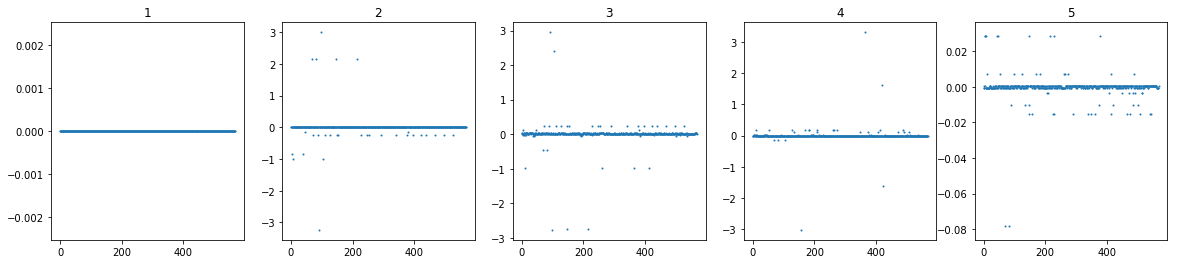

[0.0, 0.07408462808335381, 0.07468689953183964, 0.045477648944597666, 4.280072172192284e-05]


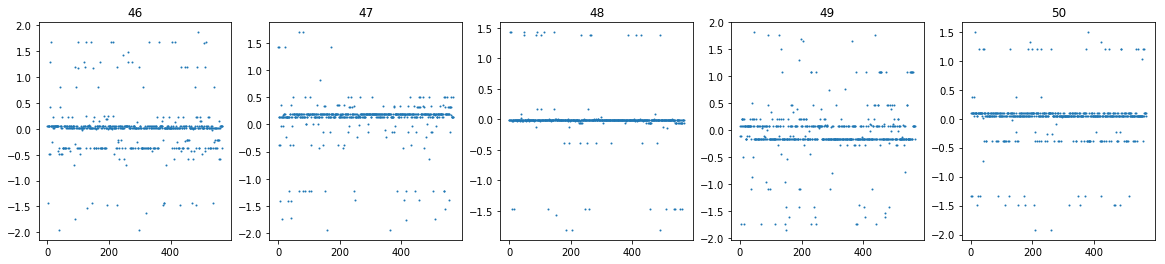

[0.2301909057679196, 0.1676825935921981, 0.12112192682168611, 0.2367489891215722, 0.17159746503710524]


In [7]:
fig = plt.figure(figsize = (20,4))
start = 0
end = 5
mse = []
for i in range(start, end):
    ax1 = fig.add_subplot(1,end-start,i-start+1)
    x_ = clf1.estimators_[i].predict(X)
    y_ = clf2.estimators_[i,0].predict(X)
    x_idx = range(len(x_))
    plt.scatter(x_idx,x_ - y_,s=1)
    plt.title(str(i+1))
    mse.append(np.mean((x_-y_)**2))
plt.show()
print mse

fig = plt.figure(figsize = (20,4))
start = n_estimators_-5
end = n_estimators_
mse = []
for i in range(start, end):
    ax1 = fig.add_subplot(1,end-start,i-start+1)
    x_ = clf1.estimators_[i].predict(X)
    y_ = clf2.estimators_[i,0].predict(X)
    x_idx = range(len(x_))
    plt.scatter(x_idx,x_ - y_,s=1)
    plt.title(str(i+1))
    mse.append(np.mean((x_-y_)**2))
plt.show()
print mse

In [8]:
print roc_auc_score(y,prob1)
print roc_auc_score(y,prob2)

0.9999999999999999
1.0


#### example 2